In [ ]:
TRAIN_DATA_DIR = '/content/chest_xray/chest_xray/train'
VALIDATION_DATA_DIR = '/content/chest_xray/chest_xray/val'
TEST_DATA_DIR = '/content/chest_xray/chest_xray/test'
ROOT_DIR = '/content'

In [ ]:
import shutil
import os

DATA_DIR = os.path.join(ROOT_DIR,'chest_xray')

if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
    print(DATA_DIR, 'is removed !')

In [ ]:
import zipfile
import os

DATA_DIR = '/content/drive/MyDrive/Git/ICT_Visual/Data'

try:
    with zipfile.ZipFile(os.path.join(DATA_DIR,'Chest_X-Ray.zip')) as target_file:
        target_file.extractall()
except Exception as err:
    print(str(err))

# 전체 데이터 개수 확인

In [ ]:
train_label_list = os.listdir(TRAIN_DATA_DIR)

print(train_label_list)
for label_name in train_label_list:
    print(f'train {label_name} => {len(os.listdir(os.path.join(TRAIN_DATA_DIR,label_name)))}')

print('================================================')

val_label_list = os.listdir(VALIDATION_DATA_DIR)
print(val_label_list)

for label_name in val_label_list:
    print(f'val {label_name} => {len(os.listdir(os.path.join(VALIDATION_DATA_DIR,label_name)))}')

print('================================================')

test_label_list = os.listdir(TEST_DATA_DIR)
print(test_label_list)

for label_name in test_label_list:
    print(f'test {label_name} => {len(os.listdir(os.path.join(TEST_DATA_DIR,label_name)))}')

['NORMAL', 'PNEUMONIA']
train NORMAL => 1342
train PNEUMONIA => 3876
['NORMAL', 'PNEUMONIA']
val NORMAL => 9
val PNEUMONIA => 9
['NORMAL', 'PNEUMONIA']
test NORMAL => 234
test PNEUMONIA => 390


# 이미지 shape

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Open CV를 통해 데이터 확인

In [ ]:
train_data_list = []
train_label_list = []

class_dict = {'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
import os
import cv2
import glob
import numpy as np
from datetime import datetime

image_label_list = os.listdir(TRAIN_DATA_DIR)    # 정답이름

for label_name in image_label_list:

    # 이미지 파일 읽어오기

    file_path = os.path.join(TRAIN_DATA_DIR, label_name)
    img_file_list = glob.glob(file_path+'/*.jpeg')

    width_list = []
    height_list = []

    # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 .jpg 파일 읽어서 리스트에 저장
    
    for img_file in img_file_list:

        try:
            src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) 

            width_list.append(src_img.shape[0])
            height_list.append(src_img.shape[1])

            src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
            src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

            train_data_list.append(src_img)
            train_label_list.append(float(class_dict[label_name]))  # 정답은 문자열을 실수로 변환

        except Exception as err:
            print(str(err), img_file)
            continue
    width_np = np.array(width_list)
    height_np = np.array(height_list)

    print(label_name, 'width avg =>', np.average(width_np), 'height avg =>', np.average(height_np))

NORMAL width avg => 1381.4310216256524 height avg => 1667.7345264727815
PNEUMONIA width avg => 825.0268387096775 height avg => 1200.4836129032258


# Train Image data generator 정의

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_gen.flow_from_directory(directory=TRAIN_DATA_DIR,
                                           batch_size=32, color_mode='rgb',
                                           class_mode='sparse',
                                           target_size=(IMG_WIDTH,IMG_HEIGHT))
validation_data = validation_gen.flow_from_directory(directory=VALIDATION_DATA_DIR,
                                                     batch_size=32, color_mode='rgb',
                                                     class_mode='sparse',
                                                     target_size=(IMG_WIDTH,IMG_HEIGHT))
test_data = test_gen.flow_from_directory(directory=TEST_DATA_DIR,
                                         batch_size=32, color_mode='rgb',                                        
                                         class_mode='sparse',
                                         target_size=(IMG_WIDTH,IMG_HEIGHT))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(train_data.class_indices)
print(train_data.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


# Sample image 출력

In [ ]:
data, label = train_data.next()

print(data.shape, label.shape)
print(label)

(32, 224, 224, 3) (32, 2)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


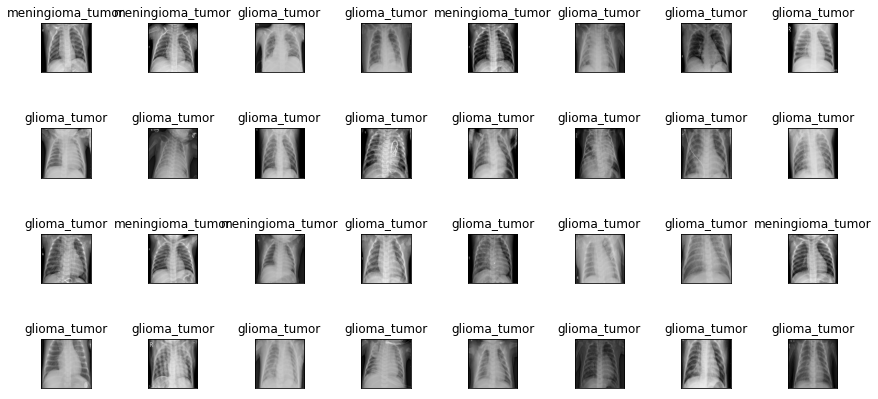

In [ ]:
import matplotlib.pyplot as plt

class_dict = { 0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}

plt.figure(figsize=(12,6))

for i in range(len(label)):

    plt.subplot(4, 8, i+1)
    plt.title(str(class_dict[label[i][0]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(data[i])

plt.tight_layout()
plt.show()

# Pre-trained model 준비

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


In [ ]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

pre_trained_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [ ]:
model.compile(optimizer=Adam(2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

start_time = datetime.now()

hist = model.fit(train_data,
                 validation_data=test_data,
                 epochs=20,
                 )

end_time = datetime.now()

print('\n\nElapsed time =>', end_time-start_time)

Epoch 1/20
163/163 [==============================] - 83s 488ms/step - loss: 0.4018 - acc: 0.8321 - val_loss: 0.8279 - val_acc: 0.7147
Epoch 2/20
163/163 [==============================] - 78s 480ms/step - loss: 0.1382 - acc: 0.9486 - val_loss: 0.6337 - val_acc: 0.8157
Epoch 3/20
163/163 [==============================] - 81s 497ms/step - loss: 0.0918 - acc: 0.9678 - val_loss: 0.5933 - val_acc: 0.8317
Epoch 4/20
163/163 [==============================] - 83s 509ms/step - loss: 0.0709 - acc: 0.9749 - val_loss: 0.6493 - val_acc: 0.8237
Epoch 5/20
163/163 [==============================] - 87s 532ms/step - loss: 0.0558 - acc: 0.9810 - val_loss: 0.7277 - val_acc: 0.8141
Epoch 6/20
163/163 [==============================] - 83s 507ms/step - loss: 0.0477 - acc: 0.9845 - val_loss: 0.7816 - val_acc: 0.8157
Epoch 7/20
163/163 [==============================] - 84s 517ms/step - loss: 0.0351 - acc: 0.9881 - val_loss: 0.8395 - val_acc: 0.8109
Epoch 8/20
163/163 [==============================] - 8

In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 6s 312ms/step - loss: 1.5174 - acc: 0.7885


[1.5173943042755127, 0.7884615659713745]

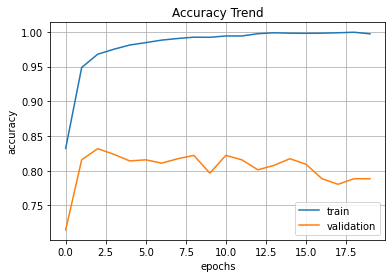

In [ ]:
plt.plot(hist.history['acc'],label='train')
plt.plot(hist.history['val_acc'],label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

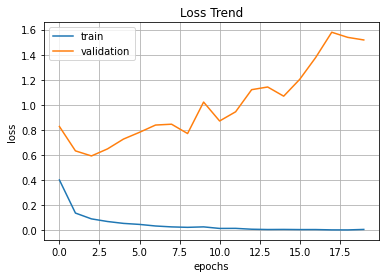

In [ ]:
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='validation')
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid()
plt.show()